<center><h1>Optimizing Hyperparameters</h1>
John Ignacio R.M. 28 Jun 2020</center>

In [13]:
#ada library
ada_parent_dir = "../"
import sys
sys.path.append(ada_parent_dir)
from ada2.data import read_dataset, split_dataset
from ada2.model import BinClassifModel2 as BC2
from ada2.plot import plot_confidence_matrix
import pandas as pd
from os.path import exists

#keras
from keras.optimizers import adam, adadelta, adagrad, adamax
from keras.backend import clear_session
import gc

In [2]:
source_path = "../processed_data/xtohh"
signal = "Xtohh2000"
bg = "Xtohh_background"
seed = 420

In [53]:
#read xtohh dataset SR 2
df = read_dataset(source_path, signal, bg, "SR", 2)
df

,EventWeight,label,m_FJpt,m_FJeta,m_FJphi,m_FJm,m_DTpt,m_DTeta,m_DTphi,m_DTm,m_dPhiFTwDT,m_dRFJwDT,m_dPhiDTwMET,m_MET,m_hhm,m_bbttpt
0,0.001020,1,885.55927,0.104927,-2.448576,127604.30,623.22710,-0.731510,0.656939,85368.720,3.105514,3.216185,-0.192894,237.887240,1631.67020,263.697630
1,0.001117,1,855.69904,0.313113,-1.859287,122862.90,449.37933,-0.306591,0.920655,55754.656,2.779941,2.848176,-0.019178,485.033330,1293.40280,463.512360
2,0.000925,1,552.47845,-0.702952,-2.549875,109091.67,631.70496,1.020756,0.610602,76213.550,3.122708,3.566858,-0.742126,104.559220,1659.84830,80.008150
3,0.001158,1,525.10590,-0.941433,-1.130162,82382.28,416.48105,0.103909,1.981465,58332.793,3.111627,3.282524,-0.130256,166.607220,1075.30920,109.524925
4,0.001120,1,916.44147,-0.683193,1.804695,115936.01,677.16440,-0.495132,-1.274429,94135.960,3.079124,3.084862,0.416606,167.350300,1595.76110,244.283460
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8801,0.006433,0,402.06714,0.109710,-1.277847,68576.34,486.71262,-0.060529,1.469456,120999.410,2.747302,2.752572,-0.883233,84.210686,891.92240,192.862270
8802,0.004849,0,542.29900,1.579771,-2.624035,84161.26,411.07132,1.205967,0.438185,56194.777,3.062220,3.084951,-0.216563,59.169407,970.41110,136.471160
8803,0.004849,0,548.63104,-0.033452,2.621298,79095.04,416.03915,0.336025,-0.553298,70408.830,3.108589,3.130470,-0.352454,34.371227,983.20233,133.526060
8804,0.007816,0,683.98340,-0.029910,-0.760806,110728.80,609.47140,0.094448,2.401307,148632.220,3.121072,3.123549,0.351719,55.616740,1320.47700,75.680750


In [4]:
lrs = [5e-3, 1e-2, 5e-2, 1e-1]
optis = [adam, adadelta, adagrad, adamax]
activs = ["relu", "softplus"]
drops = [0.2, 0.4]
splits = [(0.6, 0.2, 0.2), (0.5, 0.2, 0.3), (0.4, 0.2, 0.4)] #80:20, 70:30, 60:40
ths = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]

combs = [(lr, opti, acti, drop, split)  for lr in lrs
                                            for opti in optis
                                                for acti in activs
                                                    for drop in drops
                                                        for split in splits]

In [25]:
def f1_hyperparams(model, lr, opti, acti, drop, split, ths, comb_id, epochs):

    print(f"Comb {comb_id}:", lr, opti, acti, drop, split)

    sets = split_dataset(df, *split, seed)
    bc2_t2 = BC2(sets["x"]["test"].shape[1], lr, opti, acti, drop)

    print(f"../saved_models/tunning_hyperparams/{bc2_t2.model_name}_t2_comb{comb_id}")
    if not exists(f"../saved_models/tunning_hyperparams/{bc2_t2.model_name}_t2_comb{comb_id}.h5"):
        print("[ ] Training...")
        bc2_t2.fit(
            sets["x"]["train"], sets["y"]["train"], sets["w"]["train"],
            sets["x"]["val"], sets["y"]["val"], sets["w"]["val"],
            epochs,
            verbose = 0,
        )
        print("[~] Succesful training")
        print("[ ] Saving...")
        bc2_t2.save("../saved_models/tunning_hyperparams", f"t2_comb{comb_id}")
        print("[~] Succesful saving")
    else:
        print("[ ] Loading...")
        bc2_t2.load("../saved_models/tunning_hyperparams", f"t2_comb{comb_id}")
        print("[~] Succesful loading")

    f1_per_th = pd.DataFrame.from_dict({th: bc2_t2.f1(
                        sets["x"]["test"], sets["y"]["test"], sets["w"]["test"], th,
                    ) for th in ths}, orient="index", columns = [0, 1, "wavg"])

    clear_session()
    gc.collect()
    del bc2_t2
    
    return f1_per_th

In [31]:
def best_hyperparams_comb(combs, epochs):
    #get models and f1s
    n_combs = len(combs)
    f1_per_comb = [f1_hyperparams(BC2,*combs[i], ths, i,  epochs) for i in range(n_combs)]

    f1_per_comb = pd.concat(f1_per_comb, keys=range(n_combs), names = ["comb", "th"])
    display(f1_per_comb)

    #get best combs
    best_idx = f1_per_comb.idxmax(axis = 0)

    #return all
    return f1_per_comb, best_idx

In [7]:
f1_per_comb, model_per_comb, best_idx = best_hyperparams_comb(combs, 50)

0.3)
[ ] Training...
[~] Succesful training
[ ] Saving...
[~] Succesful saving
Comb 59: 0.01 <class 'keras.optimizers.Adam'> softplus 0.4 (0.4, 0.2, 0.4)
[ ] Training...
[~] Succesful training
[ ] Saving...
[~] Succesful saving
Comb 60: 0.01 <class 'keras.optimizers.Adadelta'> relu 0.2 (0.6, 0.2, 0.2)
[ ] Training...
[~] Succesful training
[ ] Saving...
[~] Succesful saving
Comb 61: 0.01 <class 'keras.optimizers.Adadelta'> relu 0.2 (0.5, 0.2, 0.3)
[ ] Training...
[~] Succesful training
[ ] Saving...
[~] Succesful saving
Comb 62: 0.01 <class 'keras.optimizers.Adadelta'> relu 0.2 (0.4, 0.2, 0.4)
[ ] Training...
[~] Succesful training
[ ] Saving...
[~] Succesful saving
Comb 63: 0.01 <class 'keras.optimizers.Adadelta'> relu 0.4 (0.6, 0.2, 0.2)
[ ] Training...
[~] Succesful training
[ ] Saving...
[~] Succesful saving
Comb 64: 0.01 <class 'keras.optimizers.Adadelta'> relu 0.4 (0.5, 0.2, 0.3)
[ ] Training...
[~] Succesful training
[ ] Saving...
[~] Succesful saving
Comb 65: 0.01 <class 'keras

0         1      wavg
comb th                               
0    0.2  0.243005  0.918609  0.804886
     0.3  0.285742  0.921078  0.814133
     0.4  0.284367  0.920739  0.813619
     0.5  0.284367  0.920739  0.813619
     0.6  0.283752  0.920480  0.813300
...            ...       ...       ...
191  0.4  0.712097  0.964627  0.929962
     0.5  0.712097  0.964627  0.929962
     0.6  0.712097  0.964627  0.929962
     0.7  0.744149  0.967581  0.936910
     0.8  0.744149  0.967581  0.936910

[1344 rows x 3 columns]

NameError: name 'model_per_comb' is not defined

In [32]:
f1_per_comb, best_idx = best_hyperparams_comb(combs, 50)

5, 0.2, 0.3)
../saved_models/tunning_hyperparams/BCM2_t2_comb70
[ ] Loading...
[~] Succesful loading
Comb 71: 0.01 <class 'keras.optimizers.Adadelta'> softplus 0.4 (0.4, 0.2, 0.4)
../saved_models/tunning_hyperparams/BCM2_t2_comb71
[ ] Loading...
[~] Succesful loading
Comb 72: 0.01 <class 'keras.optimizers.Adagrad'> relu 0.2 (0.6, 0.2, 0.2)
../saved_models/tunning_hyperparams/BCM2_t2_comb72
[ ] Loading...
[~] Succesful loading
Comb 73: 0.01 <class 'keras.optimizers.Adagrad'> relu 0.2 (0.5, 0.2, 0.3)
../saved_models/tunning_hyperparams/BCM2_t2_comb73
[ ] Loading...
[~] Succesful loading
Comb 74: 0.01 <class 'keras.optimizers.Adagrad'> relu 0.2 (0.4, 0.2, 0.4)
../saved_models/tunning_hyperparams/BCM2_t2_comb74
[ ] Loading...
[~] Succesful loading
Comb 75: 0.01 <class 'keras.optimizers.Adagrad'> relu 0.4 (0.6, 0.2, 0.2)
../saved_models/tunning_hyperparams/BCM2_t2_comb75
[ ] Loading...
[~] Succesful loading
Comb 76: 0.01 <class 'keras.optimizers.Adagrad'> relu 0.4 (0.5, 0.2, 0.3)
../saved_m

0         1      wavg
comb th                               
0    0.2  0.243005  0.918609  0.804886
     0.3  0.285742  0.921078  0.814133
     0.4  0.284367  0.920739  0.813619
     0.5  0.284367  0.920739  0.813619
     0.6  0.283752  0.920480  0.813300
...            ...       ...       ...
191  0.4  0.712097  0.964627  0.929962
     0.5  0.712097  0.964627  0.929962
     0.6  0.712097  0.964627  0.929962
     0.7  0.744149  0.967581  0.936910
     0.8  0.744149  0.967581  0.936910

[1344 rows x 3 columns]

In [54]:
f1_per_comb.nlargest(10, ["wavg", 1, 0])

0         1      wavg
comb th                               
72   0.3  0.926123  0.985193  0.975250
     0.4  0.920887  0.983864  0.973263
     0.5  0.918128  0.983244  0.972283
138  0.4  0.914163  0.983087  0.971485
72   0.6  0.915127  0.982561  0.971210
6    0.5  0.912200  0.982752  0.970876
138  0.3  0.909859  0.982433  0.970217
6    0.6  0.910507  0.982186  0.970120
138  0.5  0.910134  0.982199  0.970068
6    0.7  0.908352  0.981705  0.969358

# Combination 72

In [57]:
combs[72]

(0.01, keras.optimizers.Adagrad, 'relu', 0.2, (0.6, 0.2, 0.2))

In [62]:
sets = split_dataset(df, *(0.6, 0.2, 0.2), seed)
model_72 = BC2(sets["x"]["test"].shape[1], 0.01, adagrad, 'relu', 0.2)
model_72.fit(
    sets["x"]["train"], sets["y"]["train"], sets["w"]["train"],
    sets["x"]["val"], sets["y"]["val"], sets["w"]["val"],
    50,
    verbose = 1,
)

Train on 5283 samples, validate on 1761 samples
Epoch 1/50
5283/5283 [==============================] - 1s 243us/step - loss: 8.1826e-04 - val_loss: 2.8210e-04
Epoch 2/50
5283/5283 [==============================] - 1s 134us/step - loss: 5.7133e-04 - val_loss: 1.9353e-04
Epoch 3/50
5283/5283 [==============================] - 1s 135us/step - loss: 4.4599e-04 - val_loss: 1.1460e-04
Epoch 4/50
5283/5283 [==============================] - 1s 137us/step - loss: 4.1784e-04 - val_loss: 1.1271e-04
Epoch 5/50
5283/5283 [==============================] - 1s 139us/step - loss: 3.8201e-04 - val_loss: 1.1087e-04
Epoch 6/50
5283/5283 [==============================] - 1s 138us/step - loss: 3.4608e-04 - val_loss: 1.4138e-04
Epoch 7/50
5283/5283 [==============================] - 1s 132us/step - loss: 3.6661e-04 - val_loss: 1.0832e-04
Epoch 8/50
5283/5283 [==============================] - 1s 140us/step - loss: 2.9139e-04 - val_loss: 9.6056e-05
Epoch 9/50
5283/5283 [==============================] - 

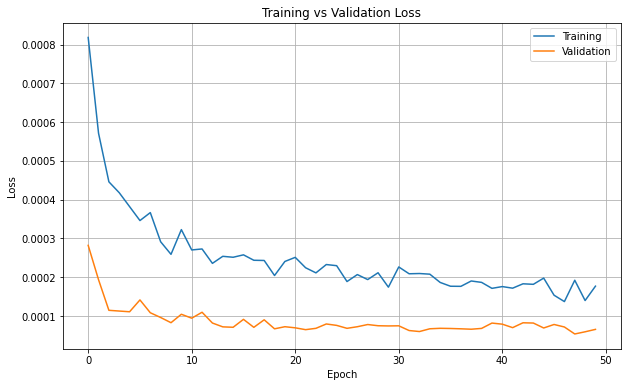

In [63]:
model_72.plot_loss()

In [89]:
eval = model_72.complete_evaluation(
    sets["x"]["test"], sets["y"]["test"], sets["w"]["test"], 0.4,
)
print("Accuracy:", eval["accuracy"])

Accuracy: 0.9699205448354143


In [90]:
pd.DataFrame(eval["weighted_class_report"])

,0,1,macro avg,weighted avg
precision,0.901474,0.974500,0.937987,0.962207
recall,0.873210,0.980684,0.926947,0.962593
f1-score,0.887117,0.977582,0.932349,0.962354
support,0.392325,1.938392,2.330717,2.330717


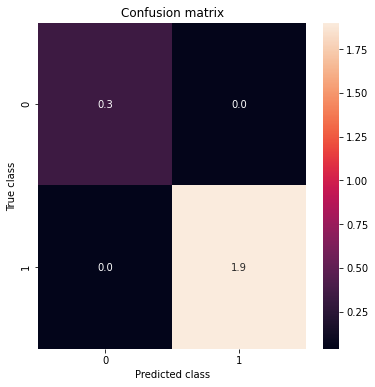

In [91]:
plot_confidence_matrix(eval["weighted_cm"], 6, 6, '.1f')

# Combination 138

In [92]:
combs[138]

(0.05, keras.optimizers.Adamax, 'softplus', 0.2, (0.6, 0.2, 0.2))

In [93]:
sets = split_dataset(df, *(0.6, 0.2, 0.2), seed)
model_138 = BC2(sets["x"]["test"].shape[1], 0.05, adamax, 'softplus', 0.2)
model_138.fit(
    sets["x"]["train"], sets["y"]["train"], sets["w"]["train"],
    sets["x"]["val"], sets["y"]["val"], sets["w"]["val"],
    50,
    verbose = 1,
)

Train on 5283 samples, validate on 1761 samples
Epoch 1/50
5283/5283 [==============================] - 1s 252us/step - loss: 0.0244 - val_loss: 4.6853e-04
Epoch 2/50
5283/5283 [==============================] - 1s 162us/step - loss: 6.2582e-04 - val_loss: 1.9951e-04
Epoch 3/50
5283/5283 [==============================] - 1s 151us/step - loss: 6.8936e-04 - val_loss: 2.5045e-04
Epoch 4/50
5283/5283 [==============================] - 1s 160us/step - loss: 5.9384e-04 - val_loss: 2.8927e-04
Epoch 5/50
5283/5283 [==============================] - 1s 154us/step - loss: 4.9565e-04 - val_loss: 1.9062e-04
Epoch 6/50
5283/5283 [==============================] - 1s 165us/step - loss: 5.4776e-04 - val_loss: 1.9273e-04
Epoch 7/50
5283/5283 [==============================] - 1s 168us/step - loss: 4.9675e-04 - val_loss: 2.0058e-04
Epoch 8/50
5283/5283 [==============================] - 1s 157us/step - loss: 3.7084e-04 - val_loss: 1.5442e-04
Epoch 9/50
5283/5283 [==============================] - 1s 1

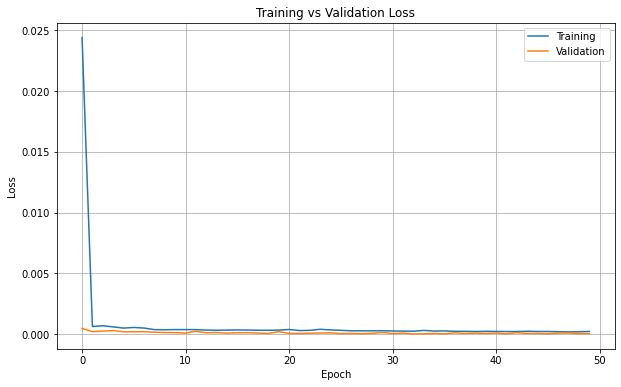

In [94]:
model_138.plot_loss()

In [104]:
eval_138 = model_138.complete_evaluation(
    sets["x"]["test"], sets["y"]["test"], sets["w"]["test"], 0.4,
)
print("Accuracy:", eval_138["accuracy"])

Accuracy: 0.9790011350737798


In [105]:
pd.DataFrame(eval_138["weighted_class_report"])

,0,1,macro avg,weighted avg
precision,0.949110,0.934787,0.941948,0.937198
recall,0.657780,0.992862,0.825321,0.936458
f1-score,0.777036,0.962949,0.869993,0.931655
support,0.392325,1.938392,2.330717,2.330717


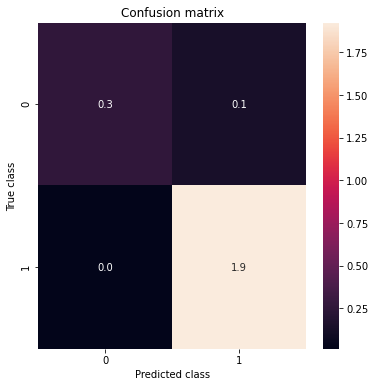

In [106]:
plot_confidence_matrix(eval_138["weighted_cm"], 6, 6, '.1f')